Plotting glycine chemical shifts
=================

In this we will demonstrate how to use Python and the magres library to process the various quantities from an ab-initio glycine magnetic shielding calculation and display them. Below is a 3D plot from JMol of two glycine molecules in its primitive unit cell with the magnetic shielding tensors represented as ellipsoids.

Populating the interactive namespace from numpy and matplotlib


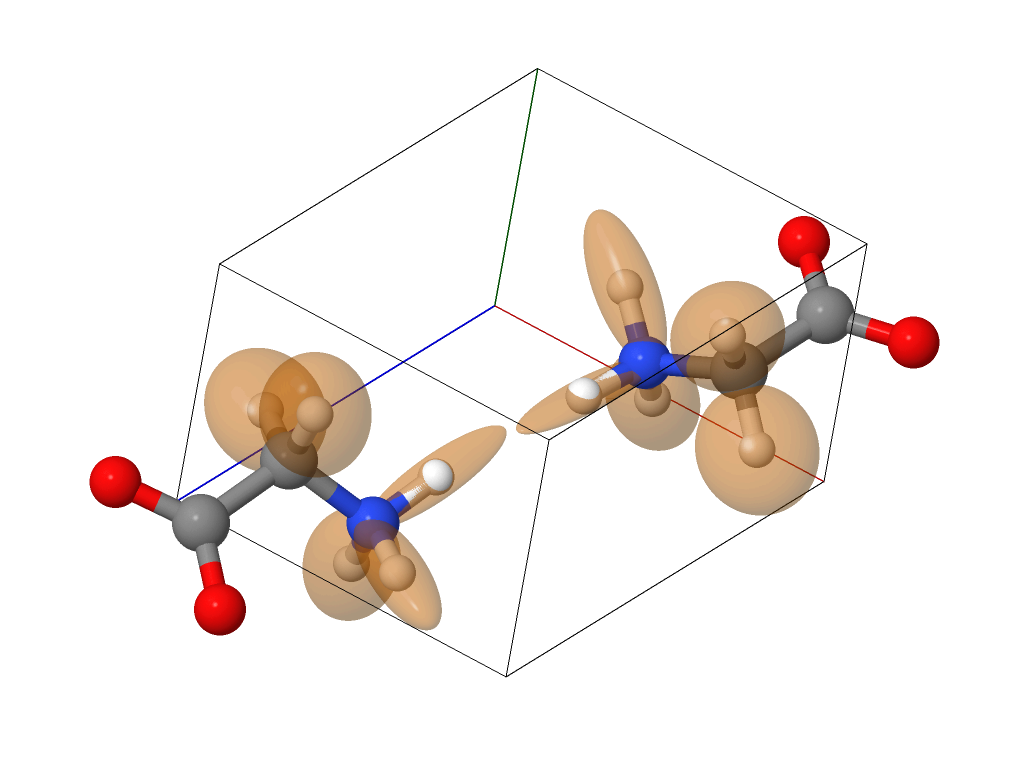

In [1]:
from __future__ import print_function
import warnings
warnings.filterwarnings("ignore") 
%pylab inline

from IPython.core.display import Image
Image(filename='glycine-relaxed.png', width=600, embed=True)

Loading the atoms
-----------------

First we load our glycine.magres file (replace with your own path) into a `MagresAtoms` structure. We've called the variable 'atoms'.

In [2]:
from magres.atoms import MagresAtoms, MagresAtomsView

In [3]:
atoms = MagresAtoms.load_magres('../samples/glycine-relaxed.magres')
atoms.calculate_bonds(1.6)

print("We have {} atoms".format(len(atoms)))

We have 20 atoms


The magres library can also generate cartoons of molecules, showing bonding and, if present, J-coupling. For example, to show all atoms within 3 Angstrom of the `C2` atom.

In [4]:
atoms.within(atoms.C2, 3.0)

<magres.atom.MagresAtomsView - 10 atoms>

We have 20 atoms because there are two glycine molecules in its primitive unit cell. Now we can extract the 1H isotropic shifts using an *array property* and print out their max and mins so we can scale our graph axes. We also set a shift on all the hydrogens in the system to make the data more comparable to experiment.

In [5]:
atoms.species('H').set_reference(30)
H_cs = atoms.species('H').ms.cs
print("H min: {:.3f} max: {:.3f}".format(min(H_cs), max(H_cs)))

H min: 2.619 max: 11.652


Gaussian smoothing
------------------

Here we use gaussian functions (the normal distribution) placed on each 1H's shift to give something resembling a "spectrum". Let's first import scipy so we can use its *scipy.stats.norm* routine to get gaussian functions.

In [6]:
import numpy, scipy, scipy.stats
import matplotlib.pyplot as plt

Gaussian functions have two parameters: mean and standard deviation. We will set the mean to be the chemical shift and then set the standard deviation to something arbitrary that it looks nice.

Let's make our axes 0 to 15 ppm. Note that these are referenced shifts and so we want to reverse the x-axis for the purpose of getting a spectrum-like plot.

In [7]:
H_xs = numpy.arange(0, 15, 0.01)
spread = 0.05
H_ys = numpy.sum([scipy.stats.norm.pdf(H_xs, cs, spread) for cs in H_cs], axis=0)

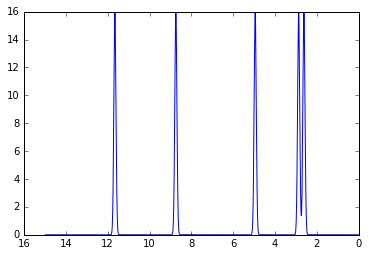

In [8]:
plt.gca().invert_xaxis()
plot(H_xs, H_ys)
show()

Compare it to the spectrum in [this paper](http://giotto.mae.virginia.edu/wp-content/uploads/2012/04/4630104D-22D8-4C2C-B616-DE294DCDD4DA.pdf). We seem to have too many peaks! In the spectrum there are only three peaks, but we have five. What's going on? Well, that NH3 group will likely undergo free rotation on a time-scale much faster than NMR frequencies. This means that we should take a mean of the chemical shifts for the NH3 hydrogens.

We need to

- Grab the N in NH3 and C in CH2
- Get the list of hydrogens bonded to each
- Take the mean of the NH3 hydrogen chemical shifts
- Store them all together with their weights

In [9]:
# Mean shifts on the H bonded to the N in NH3
H_cs1 = mean(atoms.N1.bonded.species('H').ms.cs)

# Just take the shifts on the H bonded to the C in CH2 as they are
H_cs2, H_cs3 = atoms.C2.bonded.species('H').ms.cs

# Make a list of them with weights
H_cs_ave = [(3,H_cs1), (1,H_cs2), (1,H_cs3)]

print("Average 1H shifts:", H_cs_ave)

Average 1H shifts: [(3, 8.4466509412757418), (1, 2.8710284334888918), (1, 2.6193077742995321)]


This is a list of *tuples*, with the first value of each being the strength of the peak and the second being its position. We have given the peaks strengths of 3, 1, and 1 because the first involves an average of three protons' shifts and the second two involve just one proton's shifts.

In [10]:
H_ys_ave = numpy.sum([strength*scipy.stats.norm.pdf(H_xs, cs, spread) for strength,cs in H_cs_ave], axis=0)

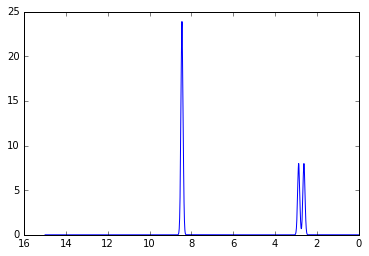

In [11]:
plt.gca().invert_xaxis()
plot(H_xs, H_ys_ave)
show()

Hurrah! It sort of looks like the spectrum. The CH2 peaks are, however, a little bit close together, and the NH3 and CH2 group are a bit far apart compared to experiment:

In [12]:
print("CH2 separation = {:.3f}, exp ~ 1ppm".format(abs(H_cs2 - H_cs3)))
print("NH3-CH2 separation = {:.3f}, exp ~ 5ppm".format(abs(H_cs1 - (H_cs2 + H_cs3)/2)))

CH2 separation = 0.252, exp ~ 1ppm
NH3-CH2 separation = 5.701, exp ~ 5ppm
